In [1]:
from featimp import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# <p style="text-align: center;">The importance of Feature Importance</p>

### <p style="text-align: center;">By: Joshua Majano</p>

When modeling, there is always the question of which features should we include? Especially in the case of a dataset with dozens, or even hundreds, of features, this can be a very *important* question. And thus, why feature importance is of particular interest for any dataset. What feature importance is is getting a relative score of a feature with the rest of the features and the target variable.

The idea of feature importance can be applied to different parts of the data analysis/modeling process. Feature importance can give us insight into the dataset, the model, and ways of how we can improve a predictive model. The scores we get from feature importance can highlight which features seem to be more/least relevant to the target variable. In the case of a model, inspecting the feature importance from a model gives insight to us as to what the model decides is relevant to predicting the target variable. All of these insights together can help us not only reduce the number of features we need to use for a model, but also give us better questions to ask of our data as to whether we may need more data or different data altogether.


Contents:
- Overview of the data and features
- Explore feature importance strategies
    - Directly with the data
    - Model based strategies
- Compare strategies
- Automatic feature selection
- Variance and empirical p-values for feature importances

In [2]:
# Load in the data
df = pd.read_csv('csgo_round_snapshots.csv')
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [3]:
df.shape

(122410, 97)

### Overview of the data and features

| Variable | Definition | Key |
|---|---|---|
| time_left | The time left in the current round. |
| ct_score | The current score of the Counter-Terrorist team. |	
| t_score | The current score of the Terrorist team. |
| map | The map the round is being played on. |	E.g. de_dust2, de_inferno and de_overpass |
| bomb_planted | If the bomb has been planted or not. |	False = No, True = Yes
| ct_health	| The total health of all Counter-Terrorist players. | Player health in range 0-100. |
| t_health | The total health of all Terrorist players. | Player health in range 0-100. |
| ct_armor | The total armor of all Counter-Terrorist players. |
| t_armor | The total armor of all Terrorist players. |
| ct_money | The total bankroll of all Counter-Terrorist players. | Amount in USD. |
| t_money | The total bankroll of all Terrorist players. | Amount in USD. |
| ct_helmets | Number of helmets on the Counter-Terrorist team. |
| t_helmets | Number of helmets on the Terrorist team. |
| ct_defuse_kits | Number of defuse kits on the Counter-Terrorist team. |
| ct_players_alive | Number of alive players on the Counter-Terrorist team. | Range 0 to 5. |
| t_players_alive | Number of alive players on the Terrorist team. | Range 0 to 5. |
| ct_weapon_X | Weapon X count on Counter-Terrorist team. | E.g. Ak47, Deagle and UMP45. |
| t_weapon_X | Weapon X count on Terrorist team. | E.g. Ak47, Deagle and UMP45. |
| ct_grenade_X | Grenade X count on Counter-Terrorist team. | E.g. HeGrenade, Flashbang. |
| t_grenade_X | Grenade X count on Terrorist team. | E.g. HeGrenade, Flashbang. |
| round_winner | Winner. | CT = Counter-Terrorist, T = Terrorist |

Here, I am will decide to drop the features "map" and "bomb_planted". As a gamer myself, knowing the map the round is played on and whether the bomb has been planted can play a significant role to the decisions a player will make. However, to make our feature importance analysis simple, we will only consider features that are numeric. Special care would be needed to handle these categorical features.

In [4]:
# Remove features that are not numeric
df = df.drop(['map', 'bomb_planted'], axis=1)

As was shown earlier, there are in fact 97(!!!) features in this dataset despite the quick overview above seeming to be far less than that. The reason for this is due the number of weaponry and tactial tools players can have in this game, which of course, can greatly affect who wins the round. 

To make our analysis and exploration easier on our machines, I will decide to split up the dataset into two datasets: one with all the weaponry and tactical tools, and another with everything else not related to the weapons. Not only will this speed up our exploration (because you can only imagine running our strategies with this many features), but we can also have a more focused exploration of the different aspects of winning a round. By splitting up the weapon features, we will more clearly see which weapons and tactical tools seem to be important to winning a round as well as to what players tend to favor more or rely on to win a round.

In [5]:
# Split up data into two sets
X_general = df.iloc[:, :14]
X_weapons = df.iloc[:, 14:-1]
y = df.iloc[:, -1]

In [6]:
# Convert y into a 0/1 label
y = LabelEncoder().fit_transform(y)

## Explore feature importance strategies

### Directly with the data

One strategy with attaining feature importance is by working directly with the data. One method, for example, is using the Spearman's rank correlation coefficient. This is similar to the common idea of correlation, usually known as Pearson's correlation coefficient, where it measures the degree of association between two variables. The difference here is that Pearson's correlation works with a linear relationship between two variables, while Spearman works with a monotonic relationship between the ranks of two variables.

Because of this, Spearman is a nice, simple method of attaining the importance of features in getting an idea of their rank association with the target variable. All we need to find the Spearman rank coefficient is our dataset X and target variable y.

Another method that we will see after taking a look at Spearman is Principal Component Analysis (PCA). This is a widely known dimensionality-reduction method commonly used to reduce the dimensionality of large data while still maintaining most of the important information. Differing from Spearman, PCA only requires the features X. From there, PCA will transform the data into a new space where the eigenvectors and eigenvalues in the new space can help to identify features that explain the most variance in that new space. Instead of features, PCA will transform the data into principal components (hence the name), where for example, if a large percentage of the variance comes from the first principal component, the eigenvectors, or "loads", associated with that component can indicate a sense of which features are relevant in the original X dataset.

But first, let's take a look at Spearman's rank correlation coefficient.

##### Spearman's rank correlation coefficient

As mentioned, to get the Spearman ranks of each feature, all we need is the original X dataset of features and the target variable y.

The function "spearman_sort" simply takes the features in X and the target y, creates a new dataframe with all the features and the target together, and makes use of the pandas method of correlation where it will calculate the Spearman correlation of each variable with one another. We then only take the column associated with the target variable and sort the rankings in order from largest to smallest.

In [7]:
spear = spearman_sort(X_general, y)
spear

[('ct_defuse_kits', 0.30893197394570737),
 ('ct_helmets', 0.30536196274346594),
 ('ct_armor', 0.29969714809161707),
 ('t_helmets', 0.2819609569823639),
 ('t_armor', 0.24270117558900736),
 ('ct_players_alive', 0.1841381341585166),
 ('ct_health', 0.14249975120282632),
 ('ct_money', 0.12098005737411444),
 ('t_money', 0.11137942946456979),
 ('t_players_alive', 0.08497922546592537),
 ('time_left', 0.07043774107015652),
 ('ct_score', 0.0625505406149957),
 ('t_health', 0.033411582740618),
 ('t_score', 0.03252470010121932)]

While the number of features here is not too large and straighforward enough to read off the ranking order, let's visualize the importances.

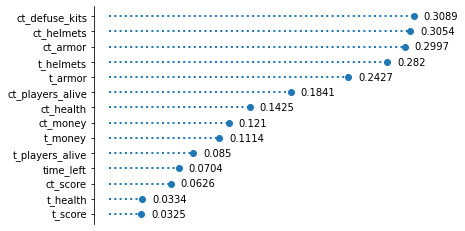

In [8]:
# Here the (6,4) refers to the size of the plot that we would like and the 0.01 is an adjusting factor for 
# placement of the value labels of our feature ranks
importance_viz(spear, (6,4), 0.01)

From this visual, we can more clearly see the difference between the rankings of each feature where the top 3 are fairly close to one another as well as there being a distinction between the top 5 features and the rest of the features.

Remembering the core gameplay, the Counter-Terrorists are out to defuse the bomb that the Terrorists are trying to plant and detonate to win the round. Because of this, there is reason to believe why the number of defuse kits, helmets and armor on the Counter-Terrorists side are the top three features in terms of rank. These seem to imply the importance of the Counter-Terrorists' ability to survive the round. It also interesting to see that the current score between the two teams plays a less relevant role in winning the round, at least according to these rankings. On a psychological level, this may suggest that either side can still win the round despite what the game score is at the time.

Let's now move on to another dimension with PCA.

##### Principal Component Analysis (PCA)

PCA is a bit more complicated compared to what we did to find the Spearman rank correlation coefficients, but to actually run through what PCA does takes only a few big steps.

1. Subtract the mean from each variable
2. Calculate the covariance matrix
3. Compute the eigenvalues and eigenvectors
4. Extract the information

That last step is not an official step for PCA, but there is a bit that needs to happen to extract information from the new space. Fortunately, the first three steps are not too bad to accomplish with Numpy as the function "PCA_sort" takes advantage of.

In [8]:
explained_var, explained_var_ratio, pca = PCA_sort(X_general)
pca

[('time_left', 3.2254883223131876),
 ('ct_score', 3.1539288805218924),
 ('t_armor', 3.136697469075853),
 ('t_health', 3.0723991559835446),
 ('t_score', 3.002214441806666),
 ('ct_armor', 2.94003078347997),
 ('t_helmets', 2.920803300997689),
 ('ct_helmets', 2.783216061291708),
 ('ct_health', 2.6872348691922285),
 ('t_money', 2.66088842394748),
 ('ct_money', 2.365584445194438),
 ('t_players_alive', 2.2169651480002552),
 ('ct_players_alive', 1.6914803087922643),
 ('ct_defuse_kits', 1.6194088050966589)]

What in the world are these numbers?

So while we did extract the rankings of each feature in descending order, what do these values represent. As mentioned, PCA transforms the data into a new space with principal components. From these principal components, we used a NxN identity matrix, where N is the number of features we had originally, and projected that matrix according to the eigenvectors and summed over the columns to get a Nx1 vector. This represents, in a way, the contribution of each feature to the variance of the data, and in turn, can give us an idea as to their importance in the original space.

So these values represent the "contribution" of each feature, though, not very interpretable as to how important they are. That is the downside with PCA, while it can help reduce the dimensionality of the original data, it comes at the cost of interpretability as there is not an easy, straightforward way of understanding what the new space is telling us. 

But despite all that, we can still get an idea as to the explained variance of each principal component, as we will see below.

In [9]:
explained_var, explained_var_ratio

(array([0.31736086, 0.19100455, 0.14555855, 0.12652188, 0.06872282,
        0.04657131, 0.03025112, 0.02101892, 0.01609331, 0.01522278,
        0.01194176, 0.00174267, 0.00250649, 0.00548298]),
 array([0.31736086, 0.50836541, 0.65392396, 0.78044584, 0.84916866,
        0.89573997, 0.92599109, 0.94701001, 0.96310333, 0.97832611,
        0.99026786, 0.99201053, 0.99451702, 1.        ]))

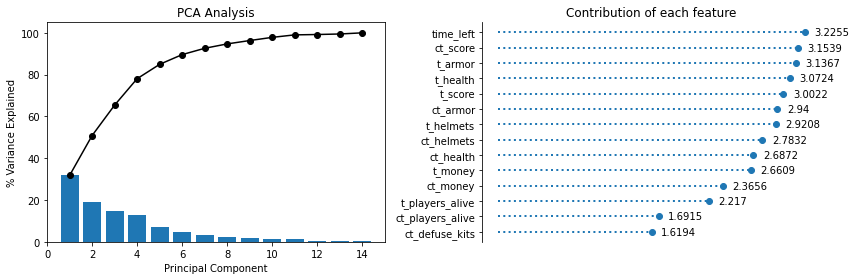

In [11]:
pca_viz(explained_var, explained_var_ratio, pca, (12,4))

From the visuals, we can see that the first principal component explains about 31% of the variance of the original data, and we get about 90% of the variance explained from the first six or seven principal components. This tells us that we could reduce our dimensionality to seven principal components (not features!) and still maintain about 90% of the information from our original data.

However, as I yelled, we can reduce down to 7 principal components, but not necessarily 7 features. Each component still takes into account all of the features, but we can get a small idea to their contribution from the visual on the right. This time, it seems almost reverse of what we saw with the Spearman rank correlation.

So which features are important to our data? There are a few more strategies we can use to further investigate.

### Model-based strategies

Rather than working directly with the data itself, we can get feature importance from an actual model. There are a few models that have feature importance built into them, like Random Forests. But we can still use other models, even if they don't have feature importance inherently, by using Drop-column importance and Permutation importance.

##### Drop-Column Importance

In Drop-column importance, we basically drop one column at a time from our features X and recalculate the metric we are interested in and keep track how much better or worse the model does without that feature. That's it!

However, we do need to have a model to work with as well as train/validation data to run our analysis. For demonstration, I will use a simple Logistic regression model and use the "accuracy" metric since we are working with a classification problem.

In [34]:
# Create a train/validation split of the data
X_train, X_val, y_train, y_val = train_test_split(X_general, y, test_size=0.2, random_state=42)

In [35]:
# As a demo, we will use a simple LogisticRegression model
model = LogisticRegression()

In [36]:
dropcol = dropcol_importance(model, X_train, y_train, X_val, y_val)
dropcol

[('t_armor', 0.024712033330610228),
 ('ct_armor', 0.018013234212891138),
 ('t_money', 0.003798709255779742),
 ('ct_money', 0.0031860142145250236),
 ('ct_health', 0.0013479290907605357),
 ('t_players_alive', 0.0005310023690874299),
 ('time_left', 0.0002450780165018651),
 ('t_health', 0.00012253900825098807),
 ('t_helmets', 0.00012253900825098807),
 ('ct_defuse_kits', 0.00012253900825098807),
 ('t_score', 8.169267216728837e-05),
 ('ct_players_alive', 8.169267216728837e-05),
 ('ct_score', 4.0846336083588675e-05),
 ('ct_helmets', 0.0)]

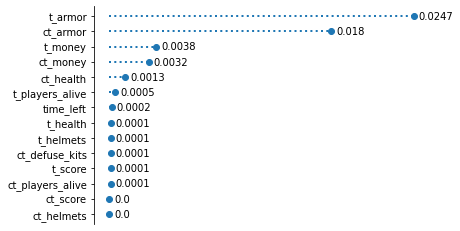

In [38]:
importance_viz(dropcol, (6,4), 0.0004)

As we can see, it seems that "t_armor" or Terrorist armor has the largest impact on the accuracy when it was dropped. Here we are looking at the absolute value of the impact, so this value could have negatively or positively affected our metric. We can also see there are many features with very, very low "importance" as our drop-column algrithm suggests. This could be due to a number of reasons, one big one being that these features could be codependent, maybe not necessarily with each other but with another feature. Drop-column importance tends to show low importance scores for codependent features because even though we drop a column out of our model, it may still retain some influence through another variable.

Because of this, we should also take a look at Permutation importance. The difference with this method is that we instead shuffle, or permute each feature one at a time and recalculate the metric accordinly. In this case, any codependent features will share importance.

In [41]:
model = LogisticRegression().fit(X_train, y_train)

In [43]:
permute = permutation_importance(model, X_val, y_val)
permute

[('ct_armor', 0.10754840290825918),
 ('t_armor', 0.08557307409525372),
 ('ct_health', 0.06433297933175397),
 ('t_health', 0.063270974593579),
 ('ct_money', 0.00951719630749126),
 ('t_money', 0.005677640715627819),
 ('time_left', 0.0021240094763499417),
 ('ct_defuse_kits', 8.169267216728837e-05),
 ('t_players_alive', 4.08463360836997e-05),
 ('t_score', 4.0846336083588675e-05),
 ('ct_score', 0.0),
 ('ct_helmets', 0.0),
 ('t_helmets', 0.0),
 ('ct_players_alive', 0.0)]

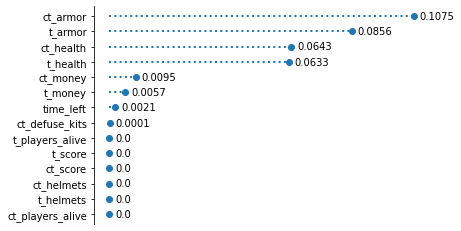

In [47]:
importance_viz(permute, (6,4), 0.002)

Now having done both, it seems that there was not much of a change in importance compared to what we saw earlier from drop-column. This could give us an indication that the low importance features might actually be not as relevant to our target variable...at least from a model perspective, and from a Logistic Regression model perspective to be exact.

Since this was only a demo with just Logistic Regression, let's compare all of the strategies we have tried so far for three different models.

## Compare strategies

What we can do now that we have a few strategies for extracting feature importance is put them all into action and see how they affect an actual model.

Coming up, we will grab the top k features from each of our methods (Spearman, PCA, Drop-column, Permutation), and run a model and test the accuracy of each model as we increase the number of top features we include into the model. We will do this using Logistic Regression, RandomForestClassifier, and XGBClassifier.

##### Logistic Regression

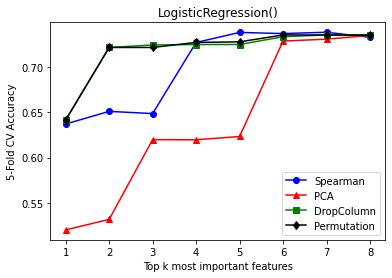

In [48]:
model = LogisticRegression()
compare_importance(model, X_general, y, metric='accuracy')

##### Random Forest

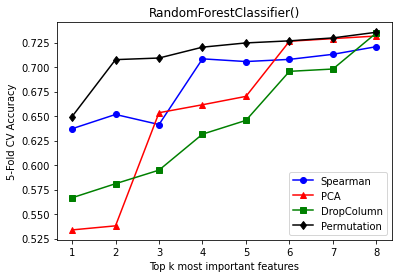

In [49]:
model = RandomForestClassifier()
compare_importance(model, X_general, y, metric='accuracy')

##### XGBClassifier

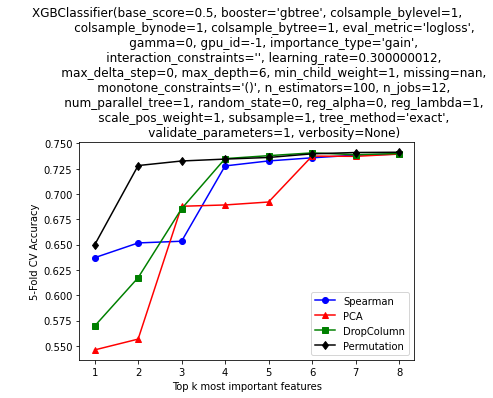

In [51]:
model = xgb.XGBClassifier(eval_metric='logloss')
compare_importance(model, X_general, y, metric='accuracy')

##### Takeaways
From each model, we have a clearer picture as to the effect of the top k features on each model and how the accuracy changes as we add more top features.

Choosing features using PCA tended to struggle the most at the beginning for each model but then quickly got better accuracy the more and more features we added. On the other hand, choosing features with Permutation importance had the strongest performance on accuracy among all three models. At least for this dataset, this can suggest us using Permutation importance as our method for selecting features and reducing the number of features for a model.

## Automatic feature selection

Now that we have several methods for finding the top features from a dataset, we can also automate this process of finding the top k features without specifying a k!

In this alogrithm, I only consider using either Spearman or PCA as the sorting method for finding the top features. We then create a baseline metric for our model where we fit all of the features. We then drop the lowest important feature according to Spearman or PCA. Then refit the model and calculate a new metric score without the dropped feature. If the score improves, we then drop the next lowest feature and continue to do so until our metric score gets worse. This will indicate that we dropped too many features.

Let's see how this works with an XGBClassifier, as it seemed to perform the best in our analysis earlier.

In [54]:
# A demo of automatic feature selection
model = xgb.XGBClassifier(eval_metric='logloss')
k_feat = autosearch(model, X_train, y_train, X_val, y_val, method='spearman')
print(f"Total features in dataset: {len(X_train.columns)}")
print(f"Total features from autosearch: {len(k_feat[0])}")

Total features in dataset: 14
Total features from autosearch: 14


In [55]:
print(f"Baseline accuracy with k features: {k_feat[1]}")

Baseline accuracy with k features: 0.783228494404052


Well that was...uneventful. According to our algorithm, the model accuracy immediately gets worse as soon as we drop one feature! Sigh. Guess we would have to keep all of the features to have the best predictive model. And considering the baseline accuracy was about 78%, it's not too shabby.

However, it does seem to make sense to include all of the features considering that each feature can have a significant role in determining who might win a round. Or at least there's an argument that can be made for each feature.

## Variance and empirical p-values for feature importances

##### Variance/Standard deviation of feature importances

One cool thing we can also do with our methods is also figure out the variance/standard deviation of our faeture importances. In the case of using Spearman, we just need to bootstrap the X and y data which will give us a sample of rank scores for each feature from which we can calculate a mean and a standard devation of.

The following functions does this bootstrapping using the Spearman rank correlation.

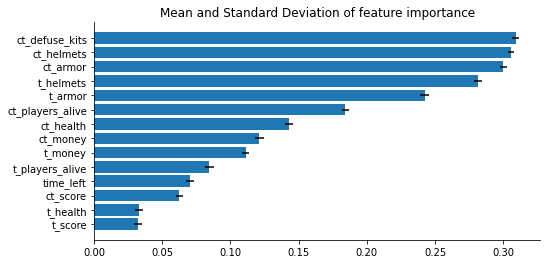

In [57]:
spearman_variance(X_general, y, (8,4), 100)

As we can see, after bootstrapping for 100 samples, we get the mean rank score for each feature as well as their respective standard deviation (or error) indicated by the small black line. There was very small deviation it seems like, so we might feel pretty confident about the rank standing for each of the features and their association to the target variable.

##### Empirical p-values (using Spearman rank correlation coefficient)

One final thing we can do is create a null distribution for the feature importance of each variable by shuffling the target variable y and then recalculating the feature importance each time. We will take our baseline to be the feature importance score of the feature on the original data and target variable. Once we have a sample of reshuffling y, we can then count how many time a feature is as important or more important than the true feature importance computed as a baseline. If this value is above 5%, then the feature importance is not signicant.

Let's try this out with the "ct_score" which was one of the lowest importance features from the Spearman rank earlier.

Text(0.5, 1.0, 'Spearman rank importance for ct_score')

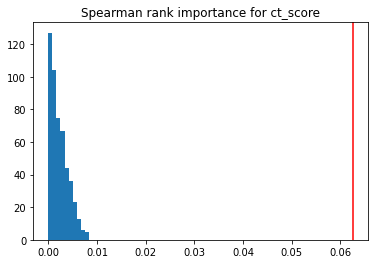

In [65]:
baseline = [item[1] for item in spear if item[0] == 'ct_score'][0]
nulls = []
for _ in range(500):
    y_shuffle = shuffle(y)
    rank_shuffle = spearman_sort(X_general, y_shuffle)
    nulls.append([item[1] for item in rank_shuffle if item[0] == 'ct_score'][0])
nulls = np.array(nulls)

plt.hist(nulls)
plt.axvline(x=baseline, color='r')
plt.title('Spearman rank importance for ct_score')

In [66]:
pval = sum(nulls > baseline) / len(nulls)
pval

0.0

Well this tells us, with a resounding yes, this feature importance for "ct_score" is significant! So we can rest assured (to a degree) that the feature importance for this feature according to Spearman is reasonable.

## References
- Terence Parr: https://github.com/parrt/msds689/blob/master/projects/featimp/featimp.md
- PCA: askpython.com/python/examples/principal-component-analysis